# **TAREA 7 - VISIÓN DE MÁQUINA**

**Universidad Nacional de Colombia** <br>
**Maestría en Ingeniería - Automatización industrial**

Juan Sebastián Hernandez Reyes; Julián Felipe Molina Grisales

In [ ]:
#Montar el drive en el colab
from google.colab import drive 
drive.mount('/content/drive') 

In [ ]:
#Importar las librerias necesarias
import cv2
from matplotlib import pyplot as plt
import numpy as np
from scipy.spatial import distance

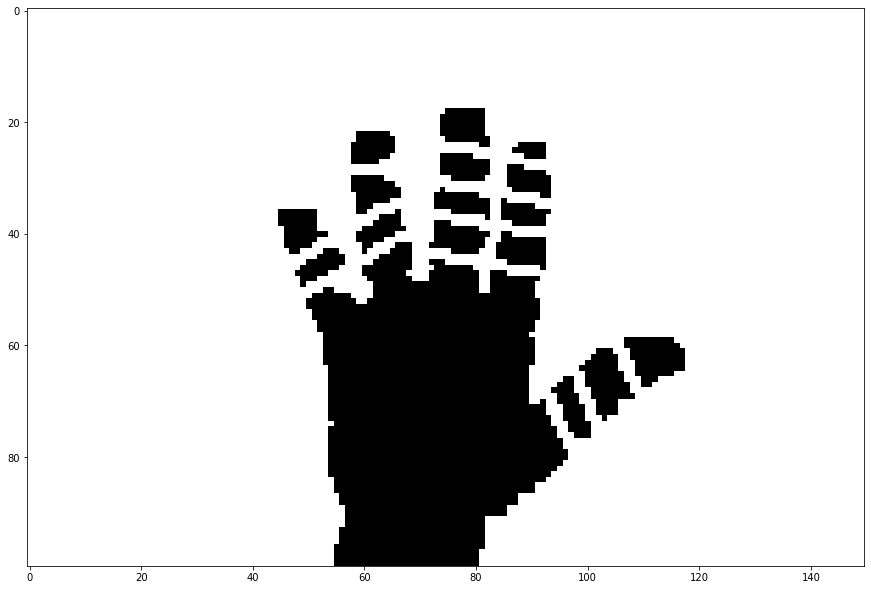

In [ ]:
#Cargar y mostrar la imagen binaria con la que se va a trabajar

img = cv2.imread('/content/mano2.jpg',0)
img = cv2.resize(img, (150,100), interpolation=cv2.INTER_CUBIC)
trh, imgBin=cv2.threshold(img, 100, 1, cv2.THRESH_BINARY)
plt.figure(1, figsize=[15,15])
plt.imshow(imgBin,cmap='gray_r')
plt.show()

### 1.   Implementar y evaluar el algoritmo de dilatación direccional.
---

---

Para realizar la dilatación direccional se debe tener en cuenta los diferentes objetos que hay en la imagen, y con estos se pueden llegar a calcular la "fuerza de atracción" que tienen estos objetos entre ellos, usando esto y la dirección de esta fuerza podemos modificar el elemento estructurante a nuestra conveniencia.

Para obtener los objetos de la imagen usamos la función ``isolateObject`` que hace uso de las funciones de contorno de OpenCV; luego para calcular el centroide de cada contorno usamos la función ``calcCentroid``

In [ ]:
def isolateObject(shape, contours, n):
    newImg=np.ones(shape)*255
    cv2.drawContours(newImg, contours, n, 0, thickness=cv2.FILLED)
    trh, newImgBin=cv2.threshold(newImg, 100, 1, cv2.THRESH_BINARY_INV)
    return newImgBin

def calcCentroid(contour):
    M = cv2.moments(contour)
    cx = int(M['m01']/M['m00'])
    cy = int(M['m10']/M['m00'])
    return (cx,cy)

A continuacion se muestran algunos de los objetos aislados con su centroide y area.

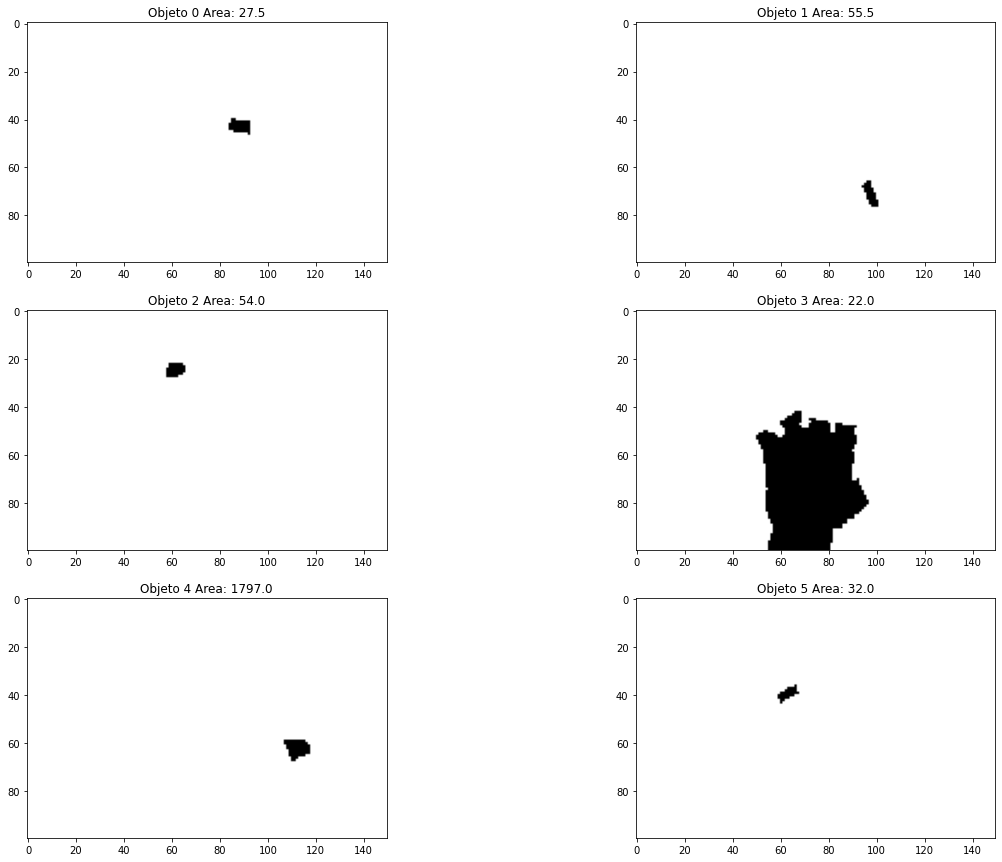

In [ ]:
plt.figure(1,figsize=[20,5*3])
contours, hierarchy = cv2.findContours(imgBin,cv2.RETR_TREE,cv2.CHAIN_APPROX_NONE)
n=len(contours)
cont=0
for i in range(6):
    obj1=isolateObject(imgBin.shape, contours, np.random.randint(0,n))
    M = cv2.moments(contours[i])
    cx = int(M['m10']/M['m00'])
    cy = int(M['m01']/M['m00'])
    obj1[cy,cx]=0
    plt.subplot(3,2,cont+1)
    plt.imshow(obj1, cmap='gray_r')
    plt.title("Objeto {} Area: {}".format(i,cv2.contourArea(contours[i])))
    cont+=1

Ahora, para realizar la dilatación en una sola dirección (de las 8 disponibles) hacemos uso de la función ``dilateDirection(img, direction, D)`` que recibe la image, y la dilata en la dirección con una "fuerza" D.

Finalmente en la función ``directionalDilation(inputImg, alpha)`` se realiza la dilatación direccional de una imagen, en lo que se da como parámetro de entrada el ``alpha`` el cual controla la relación de la distancia y la fuerza de atracción entre los objetos


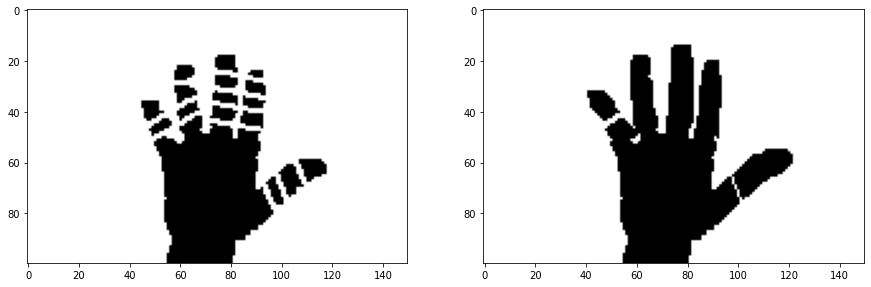

In [ ]:
def dilateDirection(img, direction, D):
    direction=direction+4
    kernel=np.zeros((3,3), np.uint8)
    kernel[1,1]=1
    kernel[round(np.cos(direction*np.pi/4))+1,round(np.sin(direction*np.pi/4))+1]=1
    return cv2.dilate(img, kernel, iterations=np.floor(D/0.25).astype(int))

def directionalDilation(inputImg, alpha):    

    #Se encuentran los contornos, centroides y areas de los objetos
    contours, hierarchy = cv2.findContours(inputImg,cv2.RETR_TREE,cv2.CHAIN_APPROX_NONE)
    centroids=list(map(calcCentroid,contours))
    areas=list(map(cv2.contourArea, contours))
    
    #Se obtiene la cantidad de objetos en la imagen
    n=len(contours)
    
    #Se inicializa la imagen de salida
    outputImg=np.zeros(inputImg.shape)
    
    #Para cada objeto se calcula el vector de la fuerza de atracción
    #y se dilata usando este vector
    for i in range(n):
        obj=isolateObject(inputImg.shape, contours, i)
        D=np.zeros(8, np.uint8)
        for j in range(n):
            if i!=j:
                a=centroids[i]
                b=centroids[j]
                
                currAngle=np.angle((a[0]-b[0])+(a[1]-b[1])*1j)*(180/np.pi)
                currAngle=currAngle+(np.less(currAngle,0))*360
                currDist=distance.euclidean(a, b)
                currArea=areas[i]*areas[j]
                
                force=currArea*np.exp(-(np.power(currDist/alpha,2)))
                
                currDir=np.floor((((currAngle-22.5)/45)+1)%8).astype(int)
                D[currDir]=D[currDir]+force
        if(np.max(D)>0):
            D=(D/np.max(D))
        for w in range(8):
            dilate = dilateDirection(obj, w, D[w])   
            outputImg=outputImg+dilate
    return np.clip(outputImg, 0, 1)


plt.figure(2, figsize=[15,20])
plt.subplot(121)
plt.imshow(imgBin, cmap='gray_r')
plt.subplot(122)
plt.imshow(directionalDilation(imgBin, 5), cmap='gray_r')
plt.show()

Vemos que en la imagen de muestra, que esta diseñada para que solo usando dilatación con algun elemento estructurante constante no pueda cerrar adecuadamente los espacios en los dedos de la mano, logra un desempeño aceptable, practicamente cerrando casi todos los espacios entre estos.


### 2.   Implementar y evaluar el algoritmo de adelgazamiento por morfología matemática.

---

---

Recordemos que para llevar a cabo el adelgazamiento de un conjunto A por el elemento estructurante B se tiene que llevar acabo la siguiente operación

$$A\otimes B = A - (A \odot B)$$

Siendo $A \odot B$ la transformada Hitt or Miss de A con el elemento B

Para este adelgazamiento simple se define la función ``thinning`` que hace uso de la función ``hitMiss`` que realiza la transformada de una imagen con un kernel dado, añade bordes a la imagen y luego evalua la transformación morfológica de la transformada.

Finalmente para hacer un adelgazamiento simétrico se debe hacer esto usando una secuencia de elementos estructurantes, elaborando rotaciones en estos, quedando definido el adelgazamiento como 

$$A \otimes \{B\} = (( ... ((A \otimes B^1)\otimes B^2)...)\otimes B^n)$$

Esta ecuación es programa en la función ``symmThin``


Text(0.5, 1.0, 'Imagen dilatada y adelgazada')

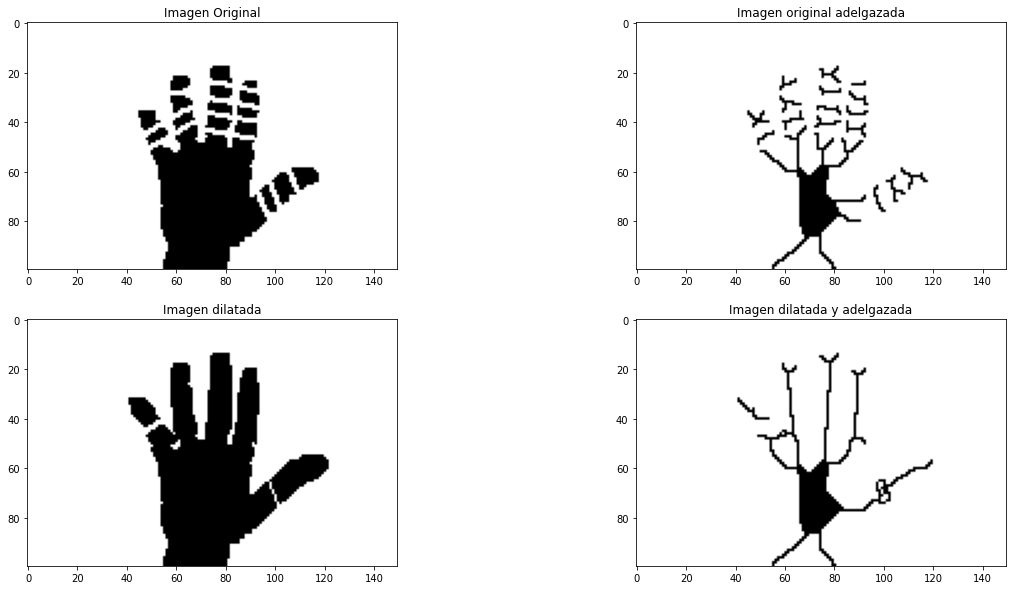

In [ ]:
def hitMiss(img, kernel):
    imgBorder=img.copy()
    imgBorder=cv2.copyMakeBorder(imgBorder,1,1,1,1, borderType=cv2.BORDER_CONSTANT)
    out=cv2.morphologyEx(imgBorder, cv2.MORPH_HITMISS, kernel)
    return out[1:imgBorder.shape[0]-1,1:imgBorder.shape[1]-1]

def thinning(A, B):
    C=hitMiss(A, B)
    C=np.equal(C,0)*1
    return np.array(C*A, dtype=np.uint8)

def symmThin(A, i):
    finish=False
    direction=0
    old=A.copy()
    while True:
        kernel=np.ones((3,3), int)*-1
        kernel[1,1]=1
        kernel[round(np.cos(-direction*np.pi/4))+1,round(np.sin(-direction*np.pi/4))+1]=1
        kernel[round(np.cos(-direction*np.pi/4+np.pi/4))+1,round(np.sin(-direction*np.pi/4+np.pi/4))+1]=1
        kernel[round(np.cos(-direction*np.pi/4-np.pi/4))+1,round(np.sin(-direction*np.pi/4-np.pi/4))+1]=1
        kernel[round(np.cos(-direction*np.pi/4+np.pi/2))+1,round(np.sin(-direction*np.pi/4+np.pi/2))+1]=0
        kernel[round(np.cos(-direction*np.pi/4-np.pi/2))+1,round(np.sin(-direction*np.pi/4-np.pi/2))+1]=0
        
        new=thinning(old, kernel)
        
        if direction>i:
            return new
        else:
            direction=direction+1
            old=new.copy()

dilatedImg=np.array(directionalDilation(imgBin, 5), dtype=np.uint8)
originalThin=symmThin(imgBin,100)
thin=symmThin(dilatedImg,100)
plt.figure(1, figsize=[20,10])

plt.subplot(2,2,1)
plt.imshow(imgBin, cmap='gray_r')
plt.title("Imagen Original")

plt.subplot(2,2,2)
plt.imshow(originalThin, cmap='gray_r')
plt.title("Imagen original adelgazada")

plt.subplot(2,2,3)
plt.imshow(dilatedImg, cmap='gray_r')
plt.title("Imagen dilatada")

plt.subplot(2,2,4)
plt.imshow(thin, cmap='gray_r')
plt.title("Imagen dilatada y adelgazada")
plt.show()

## Referencias

1.   Notas de clase y presentaciones. Visión de máquina. 2021-I.
2.   S. S. Gleason and K. W. Tobin, "Directional dilation for the connection of piece-wise objects: a semiconductor manufacturing case study,"Proceedings of 3rd IEEE International Conference on Image Processing, Lausanne, 1996, pp. 9-12 vol.3.